In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import sys
import os
import time
import pooch
import scipy.sparse as sp
from scipy.stats import entropy as sen
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import re
import seaborn as sns
import warnings

In [2]:
nb_start = time.time()

In [3]:
device = 'gpu'
max_t = 2**20

In [4]:
if device == 'gpu':
    import cupy as cp
    import cudf
    from cupyx.scipy import sparse as csp
    from cupyx.scipy.stats import entropy as cen
    import cudf as cd
    import rapids_singlecell as rsc
elif device == "cpu":
    print('WARNING: Only running on CPU, please ensure this is intended.')
else:
    raise ValueError(
        "Device should either be CPU or GPU."
    )

In [5]:
def get_xsc(device: str = "cpu"):
    if device == "gpu":
        return rsc
    if device == "cpu":
        return sc
    else:
        raise ValueError(
            "Device should either be CPU or GPU."
        )

In [6]:
def get_xp(device: str = "cpu"):
    if device == "gpu":
        return cp
    if device == "cpu":
        return np
    else:
        raise ValueError(
            "Device should either be CPU or GPU."
        )

In [7]:
def get_xsp(device: str = "cpu"):
    if device == "gpu":
        return csp
    if device == "cpu":
        return sp
    else:
        raise ValueError(
            "Device should either be CPU or GPU."
        )

In [8]:
def get_xen(device: str = "cpu"):
    if device == "gpu":
        return cen
    if device == "cpu":
        return sen
    else:
        raise ValueError(
            "Device should either be CPU or GPU."
        )

In [9]:
def get_xdf(device: str = "cpu"):
    if device == "gpu":
        return cd
    if device == "cpu":
        return pd
    else:
        raise ValueError(
            "Device should either be CPU or GPU."
        )

In [10]:
def np_as_dense(a):
    return a.toarray() if sp.issparse(a) else np.asarray(a)

In [11]:
xsc = get_xsc(device)

In [12]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [13]:
path = EXAMPLE_DATA.fetch('s1d1_filtered_feature_bc_matrix.h5')
adata = sc.read_10x_h5(path)
adata.var_names_make_unique()

/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
if device == 'gpu':
    rsc.get.anndata_to_GPU(adata)

In [15]:
xsc.pp.filter_cells(adata, min_genes=100)
xsc.pp.filter_genes(adata, min_cells=3)

raw_adata = adata.copy()

filtered out 72 cells that have less than 100 genes expressed
filtered out 14926 genes that are detected in less than 3 cells


In [16]:
if device == 'gpu':    
    dat = pd.DataFrame(
        raw_adata.X.get().T.toarray() if not isinstance(raw_adata.X, np.ndarray) else raw_adata.X.T,
        index=adata.var_names,       # genes
        columns=adata.obs_names      # cells
    )
else:
    dat = pd.DataFrame(
        raw_adata.X.T.toarray() if not isinstance(raw_adata.X, np.ndarray) else raw_adata.X.T,
        index=adata.var_names,       # genes
        columns=adata.obs_names      # cells
    )

In [17]:
adata

AnnData object with n_obs × n_vars = 8713 × 21675
    obs: 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_counts', 'n_cells'

In [18]:
xsc.pp.normalize_total(adata)
xsc.pp.log1p(adata)
xsc.pp.highly_variable_genes(adata, n_top_genes=2000)
xsc.pp.scale(adata,max_value=10)
xsc.tl.pca(adata)
rsc.get.anndata_to_CPU(adata)
xsc.pp.neighbors(adata)
xsc.tl.umap(adata)

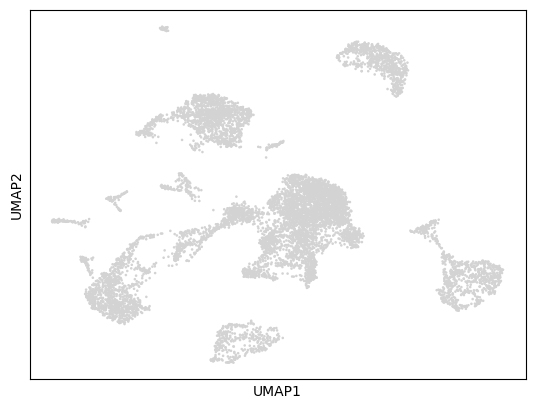

In [19]:
sc.pl.umap(adata)

In [20]:
cell_medians = np.median(dat, axis=0)
mask = dat > cell_medians

gene_detected_count = mask.sum(axis=1)

selected_genes = (gene_detected_count >= 10) & (gene_detected_count <= dat.shape[1] * 0.3)

adata = adata[:, selected_genes].copy()
raw_adata = raw_adata[:, selected_genes].copy()
dat = dat[selected_genes]

In [21]:
adata

AnnData object with n_obs × n_vars = 8713 × 16952
    obs: 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
raw_adata

AnnData object with n_obs × n_vars = 8713 × 16952
    obs: 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_counts', 'n_cells'

In [23]:
feature_space = adata.obsm['X_pca'][:, :20]

In [24]:
def build_network(X, n_neighbors):
    Xnp = X if isinstance(X, np.ndarray) else X.A if hasattr(X, "A") else np.asarray(X)
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric="euclidean").fit(Xnp)
    inds = nn.kneighbors(Xnp, return_distance=False)
    rows = np.repeat(np.arange(Xnp.shape[0]), n_neighbors)
    cols = inds[:, 1:].reshape(-1)
    data = np.ones(rows.shape[0], dtype=np.float32)
    W = sp.csr_matrix((data, (rows, cols)), shape=(Xnp.shape[0], Xnp.shape[0]))
    W = W.maximum(W.T)
    return W

In [25]:
W = build_network(feature_space, n_neighbors=5)

In [26]:
W

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 66864 stored elements and shape (8713, 8713)>

In [27]:
def visualize_network(
    affinity_m,
    adata,
    layout_key: str = "X_umap"
):
    """
    Plot a graph using:
      - affinity/adjacency matrix (sym, possibly sparse)
      - 2D visual space from adata.obsm[layout_key]
      
    """
    if type(W) != sp.csr_matrix:
        affinity_m = affinity_m.get()
    
    # --- matrix to dense for edge width calc
    A = affinity_m.toarray() if sp.issparse(affinity_m) else np.asarray(affinity_m)
    n = A.shape[0]

    if len(adata.obs_names) != n:
        raise ValueError(
            "nodes_obs_names not provided and adata.obs_names length "
            "does not match affinity matrix size."
        )
    idx = np.arange(n)
    obs_names_ordered = np.array(adata.obs_names)

    # --- get layout (2D)
    if layout_key not in adata.obsm:
        # helpful fallback suggestions
        candidates = [k for k in adata.obsm_keys() if k.lower().startswith("x_")]
        raise KeyError(
            f"'{layout_key}' not found in adata.obsm. "
            f"Available embeddings: {candidates or 'none'}"
        )
    layout_all = adata.obsm[layout_key]
    if layout_all.shape[1] < 2:
        raise ValueError(f"{layout_key} must have at least 2 dimensions (got {layout_all.shape[1]}).")
    layout = np.asarray(layout_all[idx, :2])  # align to nodes

    # --- build graph
    G = nx.from_numpy_array(A)  # undirected
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)

    # --- positions dict for networkx
    pos = {i: (layout[i, 0], layout[i, 1]) for i in range(n)}

    # --- edge widths ~ weight (map to ~0.5–1 like the R plot)
    weights = np.array([G[u][v].get("weight", 1.0) for u, v in G.edges], dtype=float)
    if weights.size:
        w_min, w_max = weights.min(), weights.max()
        if w_max > w_min:
            widths = 0.5 + 0.5 * (weights - w_min) / (w_max - w_min)
        else:
            widths = np.full_like(weights, 0.75)
    else:
        widths = []

    node_colors = "black"
    legend_handles = None
    sm = None

    # --- draw
    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw_networkx_edges(G, pos, width=widths, edge_color="grey", alpha=0.7, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5, ax=ax)

    ax.set_axis_off()

    return fig, ax


(<Figure size 800x800 with 1 Axes>, <Axes: >)

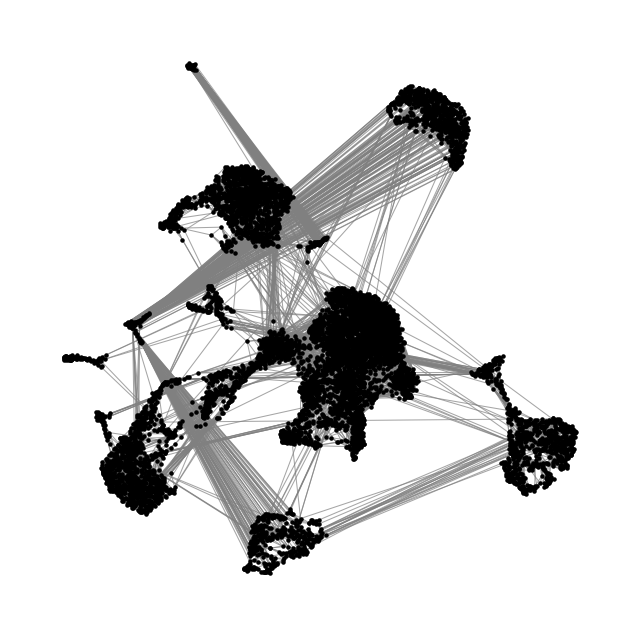

In [28]:
visualize_network(W, adata)

In [29]:
def rowwise_normalize(dat, W):
    """
    Row-normalize a genes x cells matrix, restricted to cells in W (matching column order).
    
    """
    
    # figure out cell order from W
    n = W.shape[0]
    cell_names = None

    if isinstance(dat, pd.DataFrame):
        # subset columns to match W column names
        if cell_names is None:
            # assume dat already restricted/ordered externally
            X = dat.values
            gene_names = dat.index
            cell_names = dat.columns
        else:
            X = dat.loc[:, cell_names].values
            gene_names = dat.index
    else:
        X = xp.asarray(dat)
        gene_names = np.arange(X.shape[0])
        cell_names = np.arange(X.shape[1])

    # row sums
    row_sums = X.sum(axis=1)
    keep = row_sums != 0
    X = X[keep]
    row_sums = row_sums[keep][:, None]

    rho = X / row_sums
    
    return pd.DataFrame(rho, index=np.array(gene_names)[keep], columns=cell_names)


In [30]:
dat

AAACCCAAGGATGGCT-1  AAACCCAAGGCCTAGA-1  AAACCCAAGTGAGTGC-1  \
AL627309.1                 0.0                 0.0                 0.0   
AL627309.5                 0.0                 0.0                 0.0   
LINC01409                  0.0                 0.0                 0.0   
LINC01128                  0.0                 0.0                 0.0   
LINC00115                  0.0                 0.0                 0.0   
...                        ...                 ...                 ...   
AL592183.1                 0.0                 0.0                 0.0   
AC240274.1                 0.0                 0.0                 0.0   
AC004556.3                 0.0                 1.0                 0.0   
AC233755.1                 0.0                 0.0                 0.0   
AC007325.4                 0.0                 0.0                 0.0   

            AAACCCACAAGAGGCT-1  AAACCCACATCGTGGC-1  AAACCCACATTCTCTA-1  \
AL627309.1                 0.0                 0.0                 0.0   
AL627309.5                 0.0                 0.0                 0.0   
LINC01409                  1.0                 0.0                 0.0   
LINC01128                  0.0                 0.0                 0.0   
LINC00115                  0.0                 0.0                 0.0   
...                        ...                 ...                 ...   
AL592183.1                 0.0                 0.0                 0.0   
AC240274.1                 0.0                 0.0                 0.0   
AC004556.3                 0.0                 0.0                 0.0   
AC233755.1                 0.0                 0.0                 0.0   
AC007325.4                 0.0                 0.0                 0.0   

            AAACCCAGTCCGCAGT-1  AAACCCAGTGCATACT-1  AAACCCAGTTGACGGA-1  \
AL627309.1                 0.0                 0.0                 0.0   
AL627309.5                 0.0                 0.0                 0.0   
LINC01409                  0.0                 0.0                 0.0   
LINC01128                  0.0                 0.0                 0.0   
LINC00115                  0.0                 0.0                 0.0   
...                        ...                 ...                 ...   
AL592183.1                 0.0                 0.0                 0.0   
AC240274.1                 0.0                 0.0                 0.0   
AC004556.3                 0.0                 0.0                 0.0   
AC233755.1                 0.0                 0.0                 0.0   
AC007325.4                 0.0                 0.0                 0.0   

            AAACCCATCGATACTG-1  ...  TTTGTTGAGCTTACGT-1  TTTGTTGAGGGATCGT-1  \
AL627309.1                 0.0  ...                 0.0                 0.0   
AL627309.5                 0.0  ...                 0.0                 0.0   
LINC01409                  0.0  ...                 0.0                 0.0   
LINC01128                  0.0  ...                 0.0                 0.0   
LINC00115                  0.0  ...                 0.0                 0.0   
...                        ...  ...                 ...                 ...   
AL592183.1                 1.0  ...                 0.0                 1.0   
AC240274.1                 0.0  ...                 0.0                 0.0   
AC004556.3                 0.0  ...                 0.0                 0.0   
AC233755.1                 0.0  ...                 0.0                 0.0   
AC007325.4                 0.0  ...                 0.0                 1.0   

            TTTGTTGAGGTTACCT-1  TTTGTTGAGTAGTCCT-1  TTTGTTGAGTCTAGAA-1  \
AL627309.1                 0.0                 0.0                 0.0   
AL627309.5                 0.0                 0.0                 0.0   
LINC01409                  0.0                 0.0                 0.0   
LINC01128                  0.0                 0.0                 0.0   
LINC00115                 

In [31]:
rho = rowwise_normalize(dat, W)

In [32]:
rho

AAACCCAAGGATGGCT-1  AAACCCAAGGCCTAGA-1  AAACCCAAGTGAGTGC-1  \
AL627309.1                 0.0            0.000000                 0.0   
AL627309.5                 0.0            0.000000                 0.0   
LINC01409                  0.0            0.000000                 0.0   
LINC01128                  0.0            0.000000                 0.0   
LINC00115                  0.0            0.000000                 0.0   
...                        ...                 ...                 ...   
AL592183.1                 0.0            0.000000                 0.0   
AC240274.1                 0.0            0.000000                 0.0   
AC004556.3                 0.0            0.000922                 0.0   
AC233755.1                 0.0            0.000000                 0.0   
AC007325.4                 0.0            0.000000                 0.0   

            AAACCCACAAGAGGCT-1  AAACCCACATCGTGGC-1  AAACCCACATTCTCTA-1  \
AL627309.1            0.000000                 0.0                 0.0   
AL627309.5            0.000000                 0.0                 0.0   
LINC01409             0.002079                 0.0                 0.0   
LINC01128             0.000000                 0.0                 0.0   
LINC00115             0.000000                 0.0                 0.0   
...                        ...                 ...                 ...   
AL592183.1            0.000000                 0.0                 0.0   
AC240274.1            0.000000                 0.0                 0.0   
AC004556.3            0.000000                 0.0                 0.0   
AC233755.1            0.000000                 0.0                 0.0   
AC007325.4            0.000000                 0.0                 0.0   

            AAACCCAGTCCGCAGT-1  AAACCCAGTGCATACT-1  AAACCCAGTTGACGGA-1  \
AL627309.1                 0.0                 0.0                 0.0   
AL627309.5                 0.0                 0.0                 0.0   
LINC01409                  0.0                 0.0                 0.0   
LINC01128                  0.0                 0.0                 0.0   
LINC00115                  0.0                 0.0                 0.0   
...                        ...                 ...                 ...   
AL592183.1                 0.0                 0.0                 0.0   
AC240274.1                 0.0                 0.0                 0.0   
AC004556.3                 0.0                 0.0                 0.0   
AC233755.1                 0.0                 0.0                 0.0   
AC007325.4                 0.0                 0.0                 0.0   

            AAACCCATCGATACTG-1  ...  TTTGTTGAGCTTACGT-1  TTTGTTGAGGGATCGT-1  \
AL627309.1            0.000000  ...                 0.0            0.000000   
AL627309.5            0.000000  ...                 0.0            0.000000   
LINC01409             0.000000  ...                 0.0            0.000000   
LINC01128             0.000000  ...                 0.0            0.000000   
LINC00115             0.000000  ...                 0.0            0.000000   
...                        ...  ...                 ...                 ...   
AL592183.1            0.001642  ...                 0.0            0.001642   
AC240274.1            0.000000  ...                 0.0            0.000000   
AC004556.3            0.000000  ...                 0.0            0.000000   
AC233755.1            0.000000  ...                 0.0            0.000000   
AC007325.4            0.000000  ...                 0.0            0.015152   

            TTTGTTGAGGTTACCT-1  TTTGTTGAGTAGTCCT-1  TTTGTTGAGTCTAGAA-1  \
AL627309.1            0.000000                 0.0                 0.0   
AL627309.5            0.000000                 0.0                 0.0   
LINC01409             0.000000                 0.0                 0.0   
LINC01128             0.000000                 0.0                 0.0   
LINC00115             0.00

In [33]:
def doubly_stochastic(W, device, max_iter: int = 100, tol: float = 1e-6):
    """
    Convert a symmetric affinity matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    """

    xp = get_xp(device)
    
    r = xp.ones((W.shape[0], 1), dtype=W.dtype)
    c = xp.ones((1, W.shape[1]), dtype=W.dtype)
    for _ in range(max_iter):
        r_old = r
        c_old = c
        r = 1.0 / (W @ c.T + 1e-12)
        c = 1.0 / (r.T @ W + 1e-12)
        if xp.max(xp.abs(r - r_old)) < tol and xp.max(xp.abs(c - c_old)) < tol:
            break
            
    P = (r * W) * c
    
    return P


def construct_diffusion_operators(
    W, 
    device,
    max_time    
):
    """
    Constructs a list of diffusion operators for a given symmetric affinity matrix of a graph.
    
    """
    
    xp = get_xp(device)
    xsp = get_xsp(device)
    
    print("Creating diffusion operators...")

    if hasattr(W, "toarray"):
        W_dense = W.toarray()
    else:
        W_dense = W

    W_dense = xp.asarray(W_dense)
    
    P = doubly_stochastic(W_dense, device)
    
    n = P.shape[0]
    
    if max_time < 1:
        raise ValueError("Incorrect diffusion time, no propagation (max_time must be >= 1)")
    
    # Initialize list with identity matrix (t=0)
    P_dict = {0: xsp.identity(n, format='csr')}
    
    # Current P matrix
    P_current = P.copy()
    t = 1
    max_steps = int(xp.floor(xp.log2(max_time)))
    
    # Convergence criterion: check if diagonal approaches n
    convergence_threshold = n
    
    while t <= max_steps:
        # Check convergence: if diagonal elements approach uniform distribution
        diag_check = xp.abs((n * xp.diag(P_current)) * n - n)
        max_deviation = xp.max(diag_check)
        
        print(f"Step {t}: max deviation from convergence = {max_deviation}")
        
        if max_deviation < convergence_threshold:
            print(f"Converged at step {t} (time = {2**(t-1)})")
            break
        
        # Compute P^(2^t) = P^(2^(t-1)) * P^(2^(t-1))
        P_current = P_current @ P_current
        
        # Store as sparse matrix
        P_dict[2**t] = xsp.csc_matrix(P_current)
        
        t += 1
    
    actual_max_time = 2**(t-1) if t > 1 else 0
    print(f"Max diffusion time: {actual_max_time}")
    print(f"Total operators created: {len(P_dict)}")
    
    return P_dict

In [34]:
start_time = time.time()
P_ls = construct_diffusion_operators(W, device, max_time=max_t)
end_time = time.time()
execution_time = end_time - start_time
print(f"{max_t} Diffusion Execution time: {execution_time} seconds")

Creating diffusion operators...
Step 1: max deviation from convergence = 8713.0
Step 2: max deviation from convergence = 25809436.0
Step 3: max deviation from convergence = 10944500.0
Step 4: max deviation from convergence = 7396620.0
Step 5: max deviation from convergence = 5266180.5
Step 6: max deviation from convergence = 3452121.0
Step 7: max deviation from convergence = 1521881.625
Step 8: max deviation from convergence = 898192.4375
Step 9: max deviation from convergence = 605454.1875
Step 10: max deviation from convergence = 281066.28125
Step 11: max deviation from convergence = 63136.625
Step 12: max deviation from convergence = 9905.556640625
Step 13: max deviation from convergence = 1066.939453125
Converged at step 13 (time = 4096)
Max diffusion time: 4096
Total operators created: 13
1048576 Diffusion Execution time: 0.8726739883422852 seconds


In [35]:
def visualize_diffusion(
    coord,
    rho,
    gene_name,
    P_ls=None,
    W=None
):
    """
    Visualize diffusion of an initial state over dyadic times.
    """
    coord = np.asarray(coord)
    N = coord.shape[0]

    init = np.asarray(rho.loc[gene, adata.obs_names].values)
    # Make it a (1, N) row vector
    if init.ndim == 1:
        init = init[None, :]
    if init.shape[0] != 1 and init.shape[1] == 1:
        init = init.T

    if P_ls is None:
        raise ValueError("Provide P_ls.")
        
    times = np.quantile(list(P_ls.keys()), [0, 0.33, 0.67, 1], method='higher')

    # --- compute multi_state for each time ---
    states = []
    max_vals = []
    for t in times:
        P = P_ls[t]
        P = P.get() if hasattr(P, "get") else P
        P = P if sp.issparse(P) else np.asarray(P)
        # init is (1,N); want (N, ) result transposed to (N,)
        state = (init @ P).ravel()
        states.append(state)
        max_vals.append(np.max(state) if state.size else 0.0)

    multi_state = np.column_stack(states)  # shape (N, T)
    # normalize each column to [0,1]
    col_max = np.array(max_vals)
    multi_state_norm = multi_state / col_max

    cmap = LinearSegmentedColormap.from_list("gene_grad", ["lightgrey", "blue"])

    # --- plot panels in one row ---
    n_panels = len(times)
    fig_w = 4 * n_panels
    fig_h = 4
    fig, axes = plt.subplots(1, n_panels, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes[0]

    # helper to build title like R: T=0 or T=2^{k}
    def _panel_title(t):
        if t == 0:
            return r"$T = 0$"
        k = int(np.log2(t))
        return rf"$T = 2^{{{k}}}$"

    for j, ax in enumerate(axes):
        vals = multi_state_norm[:, j]
        # order points so high values on top
        order = np.argsort(vals)
        x = coord[order, 0]
        y = coord[order, 1]
        c = vals[order]
        
        sc = ax.scatter(x, y, c=c, s=5, cmap=cmap, vmin=0.0, vmax=1.0, linewidths=0)
        ax.set_title(_panel_title(times[j]), fontsize=14, fontweight="bold")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_frame_on(False)
        
        cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cb.set_label("Density", fontsize=10)
        cb.set_ticks([0.0, 1.0])

    if gene_name:
        fig.suptitle(gene_name, fontsize=18, fontweight="bold", y=0.98)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig, axes

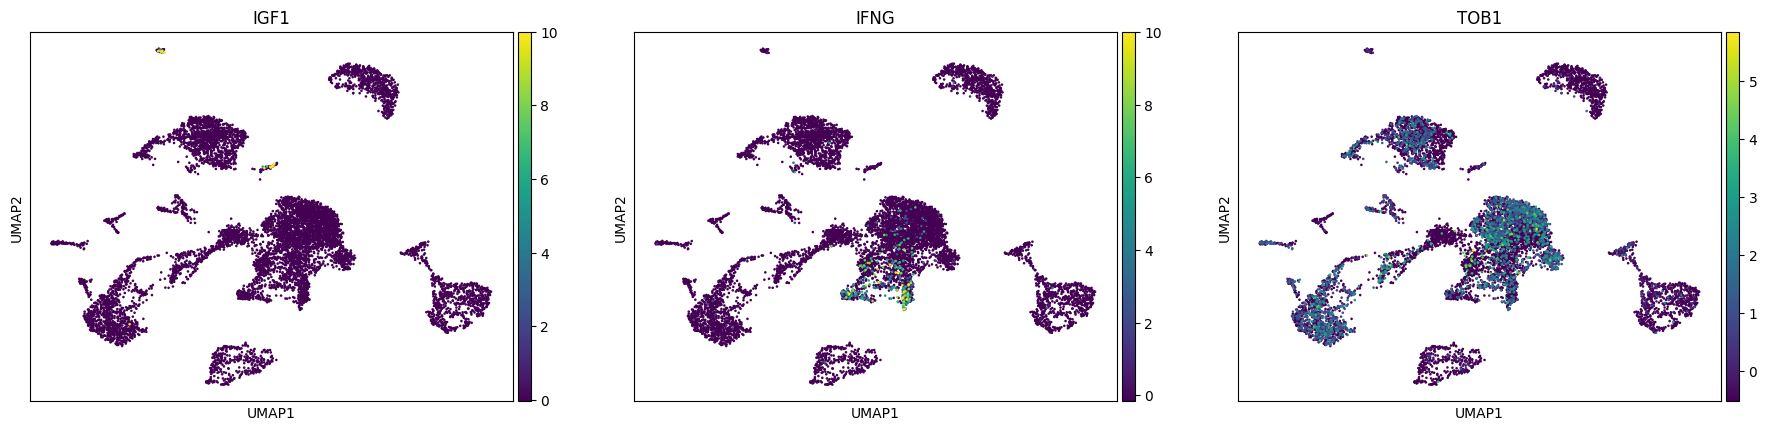

In [36]:
sc.pl.umap(adata, color = ['IGF1','IFNG','TOB1'])

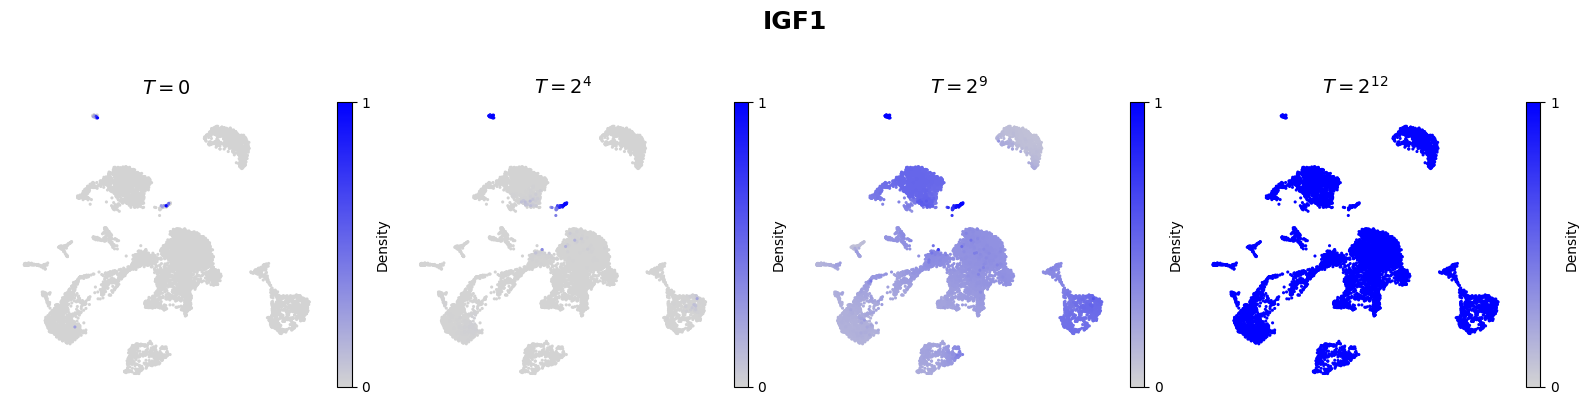

In [37]:
gene = 'IGF1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene
)

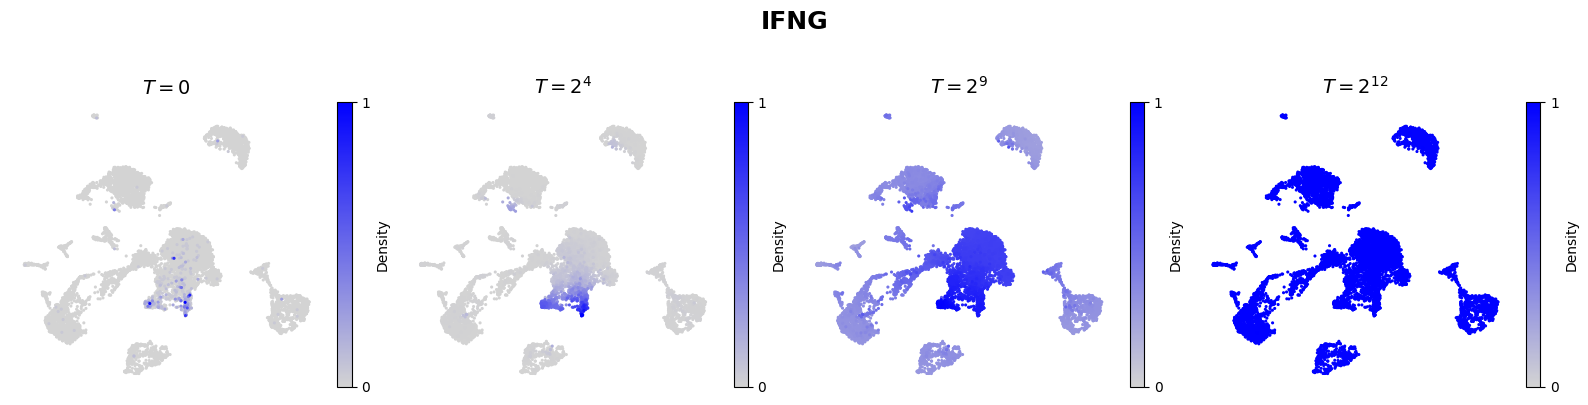

In [38]:
gene = 'IFNG'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene
)

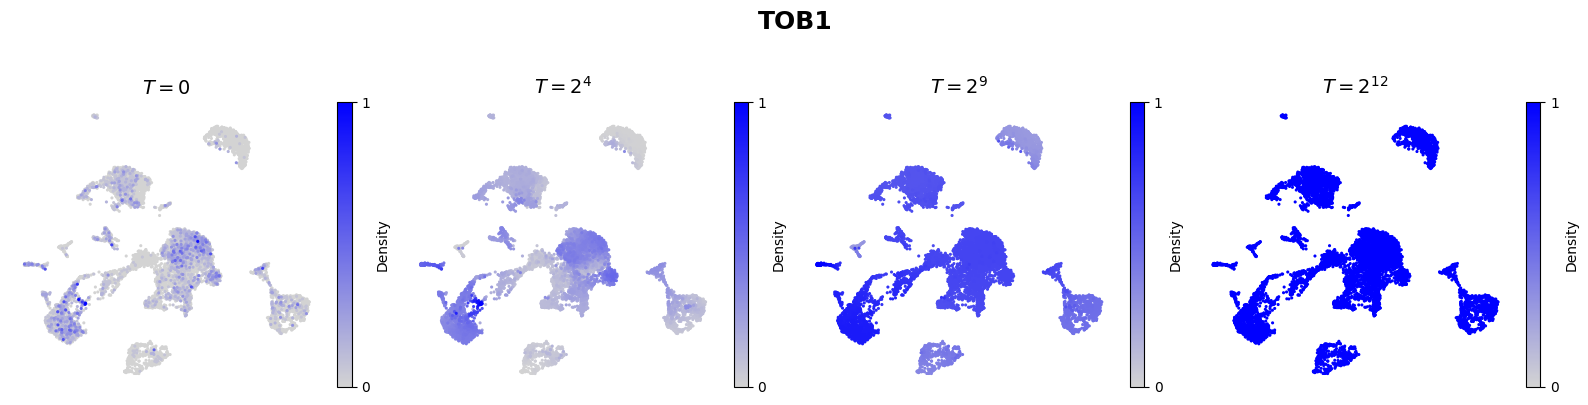

In [39]:
gene = 'TOB1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene
)

In [40]:
def calculate_score_profile(
    W,
    rho,
    P_ls,
    device
):
    
    xp = get_xp(device)
    xen = get_xen(device)
    xdf = get_xdf(device)
    
    Wn = W.shape[0]

    gene_names = rho.index.copy()
    X = rho.values
    X = xp.asarray(X)
    
    if Wn != X.shape[1] and Wn == X.shape[0]:
        X = X.T

    if Wn != X.shape[1]:
        raise ValueError("Check dims!")

    final_state = xp.full(Wn, 1.0 / Wn, dtype=float)

    # ----- compute per-time scores and cbind -----
    per_time_frames = []
    for P in P_ls:
              
        t = xen(X, (X @ P_ls[P]), axis=1)
        df_t = xdf.DataFrame(t, index=xp.arange(X.shape[0]))

        df_t.columns = [f"{col}_{P}" for col in df_t.columns]
        per_time_frames.append(df_t)

        print(f"Completed scoring for time {P}")

    score_df = xdf.concat(per_time_frames, axis=1)
    score_df.index = gene_names

    if device == 'gpu':
        X, final_state = xp.broadcast_arrays(X, final_state) # array broadcast not internally managed in cupy
    
    max_score = xen(X, final_state, axis=1)
    max_df = xdf.DataFrame(max_score, index=xp.arange(X.shape[0]))
    max_df.index = gene_names
    
    score_df = xdf.concat([score_df, max_df], axis=1)

    if device == 'gpu':
        score_df = score_df.to_pandas()

    return score_df

In [41]:
X = rho.values

In [42]:
start_time = time.time()
score_df = calculate_score_profile(
    W = W,
    rho = rho,
    P_ls = P_ls,
    device = device
)
end_time = time.time()
execution_time = end_time - start_time
print(f"{max_t} Score Execution time: {execution_time} seconds")

Completed scoring for time 0
Completed scoring for time 2
Completed scoring for time 4
Completed scoring for time 8
Completed scoring for time 16
Completed scoring for time 32
Completed scoring for time 64
Completed scoring for time 128
Completed scoring for time 256
Completed scoring for time 512
Completed scoring for time 1024
Completed scoring for time 2048
Completed scoring for time 4096
1048576 Score Execution time: 45.91153025627136 seconds


In [43]:
score_df

0_0       0_2       0_4       0_8      0_16      0_32      0_64  \
AL627309.1  0.0  1.828948  2.791358  3.857164  4.659682  5.145946  5.427519   
AL627309.5  0.0  1.674847  2.382705  2.985025  3.338952  3.511841  3.614352   
LINC01409   0.0  1.483764  2.022780  2.418192  2.606417  2.703040  2.773392   
LINC01128   0.0  1.006263  1.309046  1.512206  1.603367  1.648974  1.685369   
LINC00115   0.0  1.736224  2.529843  3.279760  3.723930  3.915089  4.005074   
...         ...       ...       ...       ...       ...       ...       ...   
AL592183.1  0.0  1.335490  1.789288  2.107244  2.260722  2.358647  2.458236   
AC240274.1  0.0  1.744065  2.601721  3.462709  4.008636  4.263977  4.421663   
AC004556.3  0.0  1.030028  1.336187  1.551586  1.681898  1.787848  1.896377   
AC233755.1  0.0  1.661047  2.261656  2.836627  3.320771  3.733104  4.016112   
AC007325.4  0.0  1.610886  2.305155  3.004498  3.532091  3.846930  4.077541   

               0_128     0_256     0_512    0_1024    0_2048    0_4096  \
AL627309.1  5.564531  5.657625  5.733522  5.800491  5.840962  5.852551   
AL627309.5  3.699465  3.801140  3.971266  4.238175  4.469574  4.524757   
LINC01409   2.835397  2.898672  2.955365  2.997597  3.023739  3.031213   
LINC01128   1.725723  1.786220  1.900177  2.095821  2.291564  2.354734   
LINC00115   4.056680  4.094358  4.129021  4.163755  4.186215  4.192171   
...              ...       ...       ...       ...       ...       ...   
AL592183.1  2.557633  2.640937  2.699906  2.748736  2.778136  2.786280   
AC240274.1  4.530312  4.613212  4.683085  4.747336  4.794527  4.809215   
AC004556.3  2.004318  2.112487  2.229808  2.355954  2.439807  2.457887   
AC233755.1  4.280920  4.710338  5.336922  5.761220  5.958115  6.010099   
AC007325.4  4.298040  4.522533  4.692195  4.822299  4.906347  4.924390   

                   0  
AL627309.1  5.853700  
AL627309.5  4.526448  
LINC01409   3.031843  
LINC01128   2.359099  
LINC00115   4.192639  
...              ...  
AL592183.1  2.787117  
AC240274.1  4.810540  
AC004556.3  2.458467  
AC233755.1  6.014232  
AC007325.4  4.924931  

[16952 rows x 14 columns]

In [44]:
def obtain_lmds(score_df):
    """
    Compute LMDS (cumulative normalized diffusion KL score).
    """

    cols = score_df.columns.astype(str)
    score_cols = [c for c in cols if c.startswith("0_")]
    
    denom = score_df[0].replace(0, np.nan)
    norm_scores = score_df.copy()
    for col in score_df.columns:
        norm_scores[col] = score_df[col] / denom
    #norm_scores = (score_df).div(denom, axis=1) #not currently supported
    cum_score = norm_scores[score_cols].sum(axis=1)

    cum_score = cum_score.fillna(0.0)
    cum_score.name = "LMDS"
    
    norm_scores = norm_scores.drop(0, axis=1)
    
    return norm_scores, cum_score

In [87]:
def visualize_score_pattern(
    score_df,
    genes,
    figsize=(10, 6)
):

    # Validate genes
    genes = list(genes)
    missing = [g for g in genes if g not in score_df.index]
    if missing:
        raise ValueError(f"Genes not found: {missing[:3]}...")

    # Subset to genes of interest
    score_df = score_df.loc[genes].copy()
    
    # Find score columns (pattern: profile_time)
    score_cols = []
    pat = re.compile(r"^(.*)_(\d+)$")
    for col in score_df.columns:
        if pat.match(col):
            score_cols.append(col)
    
    # Melt to long format for plotting
    score_df['gene'] = score_df.index
    df = score_df.melt(id_vars=['gene'], value_vars=score_cols, 
                       var_name='time_col', value_name='score')
    
    # Extract time from column names
    df['time'] = df['time_col'].str.extract(r'_(\d+)$')[0].astype(int)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each gene as a separate line
    for gene in genes:
        gene_data = df[df['gene'] == gene].sort_values('time')
        ax.plot(gene_data['time'], gene_data['score'], 
                marker='o', label=gene, linewidth=2)

    ax.set_xscale('symlog', base=2)
    
    # Styling
    ax.set_xlabel('Time')
    ax.set_ylabel("Normalized Diffusion KL Score")
    ax.set_title('Gene Scores Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

In [46]:
norm_scores, lmd_scores = obtain_lmds(score_df)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Gene Scores Over Time'}, xlabel='Time', ylabel='Normalized Diffusion KL Score'>)

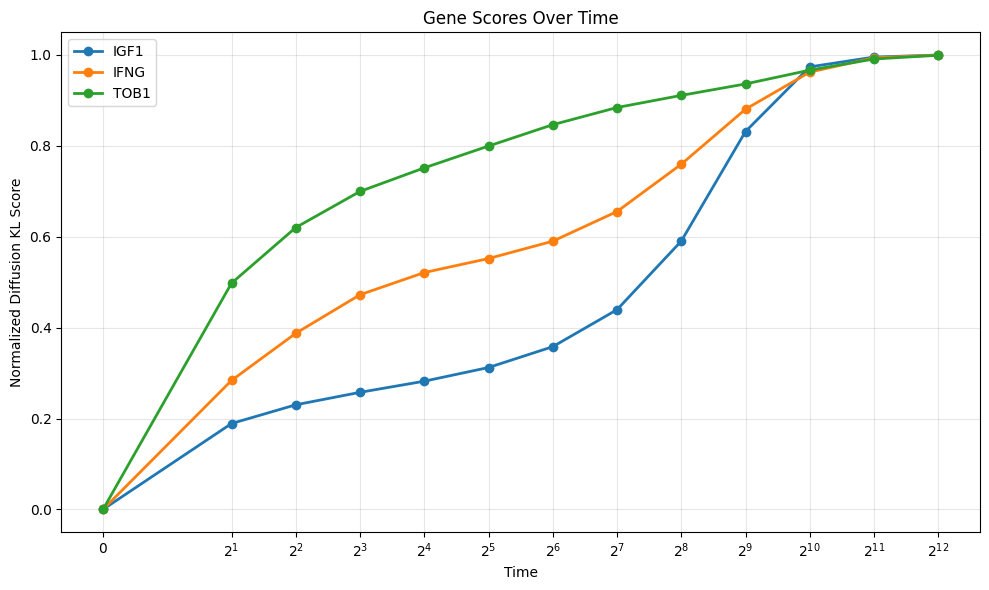

In [88]:
visualize_score_pattern(norm_scores, genes = ['IGF1','IFNG','TOB1'])

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Gene Scores Over Time'}, xlabel='Time', ylabel='Normalized Diffusion KL Score'>)

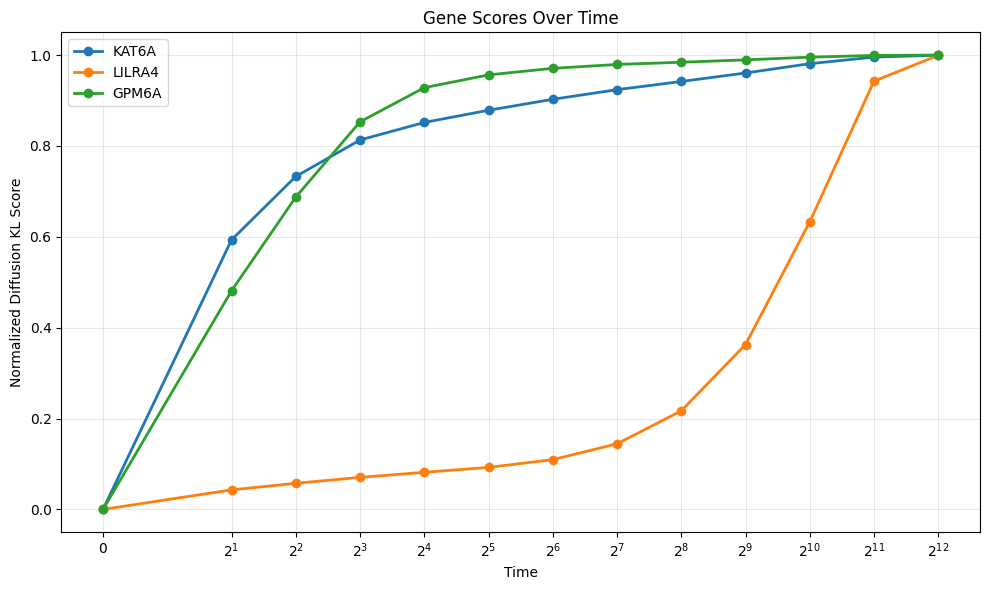

In [89]:
visualize_score_pattern(norm_scores, genes = ['KAT6A', 'LILRA4', 'GPM6A'])

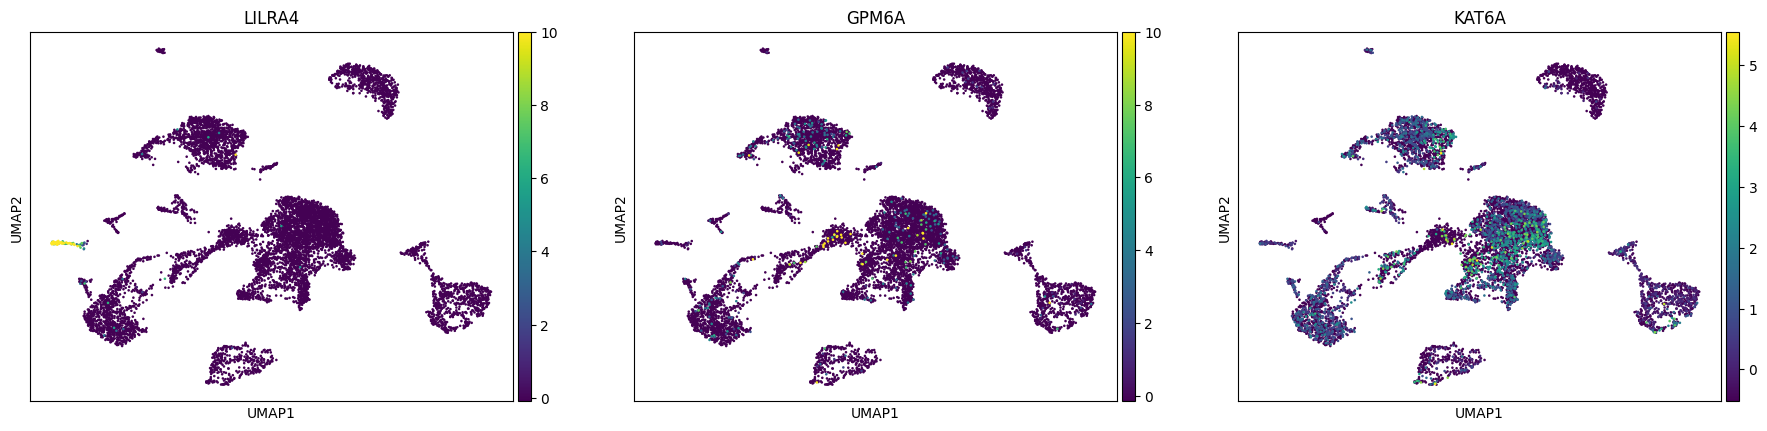

In [50]:
sc.pl.umap(adata, color = ['LILRA4', 'GPM6A', 'KAT6A'])

In [51]:
lmd_scores

AL627309.1     9.935647
AL627309.5     9.325656
LINC01409     10.472034
LINC01128      8.867565
LINC00115     10.497473
                ...    
AL592183.1    10.233245
AC240274.1    10.119541
AC004556.3     9.308316
AC233755.1     8.294813
AC007325.4     9.450470
Name: LMDS, Length: 16952, dtype: float32

In [52]:
sort_score = lmd_scores.sort_values()

In [53]:
sort_score

SNCA        3.733672
LILRA4      3.752784
ALAS2       3.872074
SLC4A1      3.885415
HEMGN       4.077516
             ...    
PLCL2      10.873769
CRTC2      10.876394
ZNF335     10.877095
KHNYN      10.927415
ST3GAL1    10.961809
Name: LMDS, Length: 16952, dtype: float32

In [54]:
top = sort_score[:25]
bot = sort_score[int(len(sort_score)-25):]

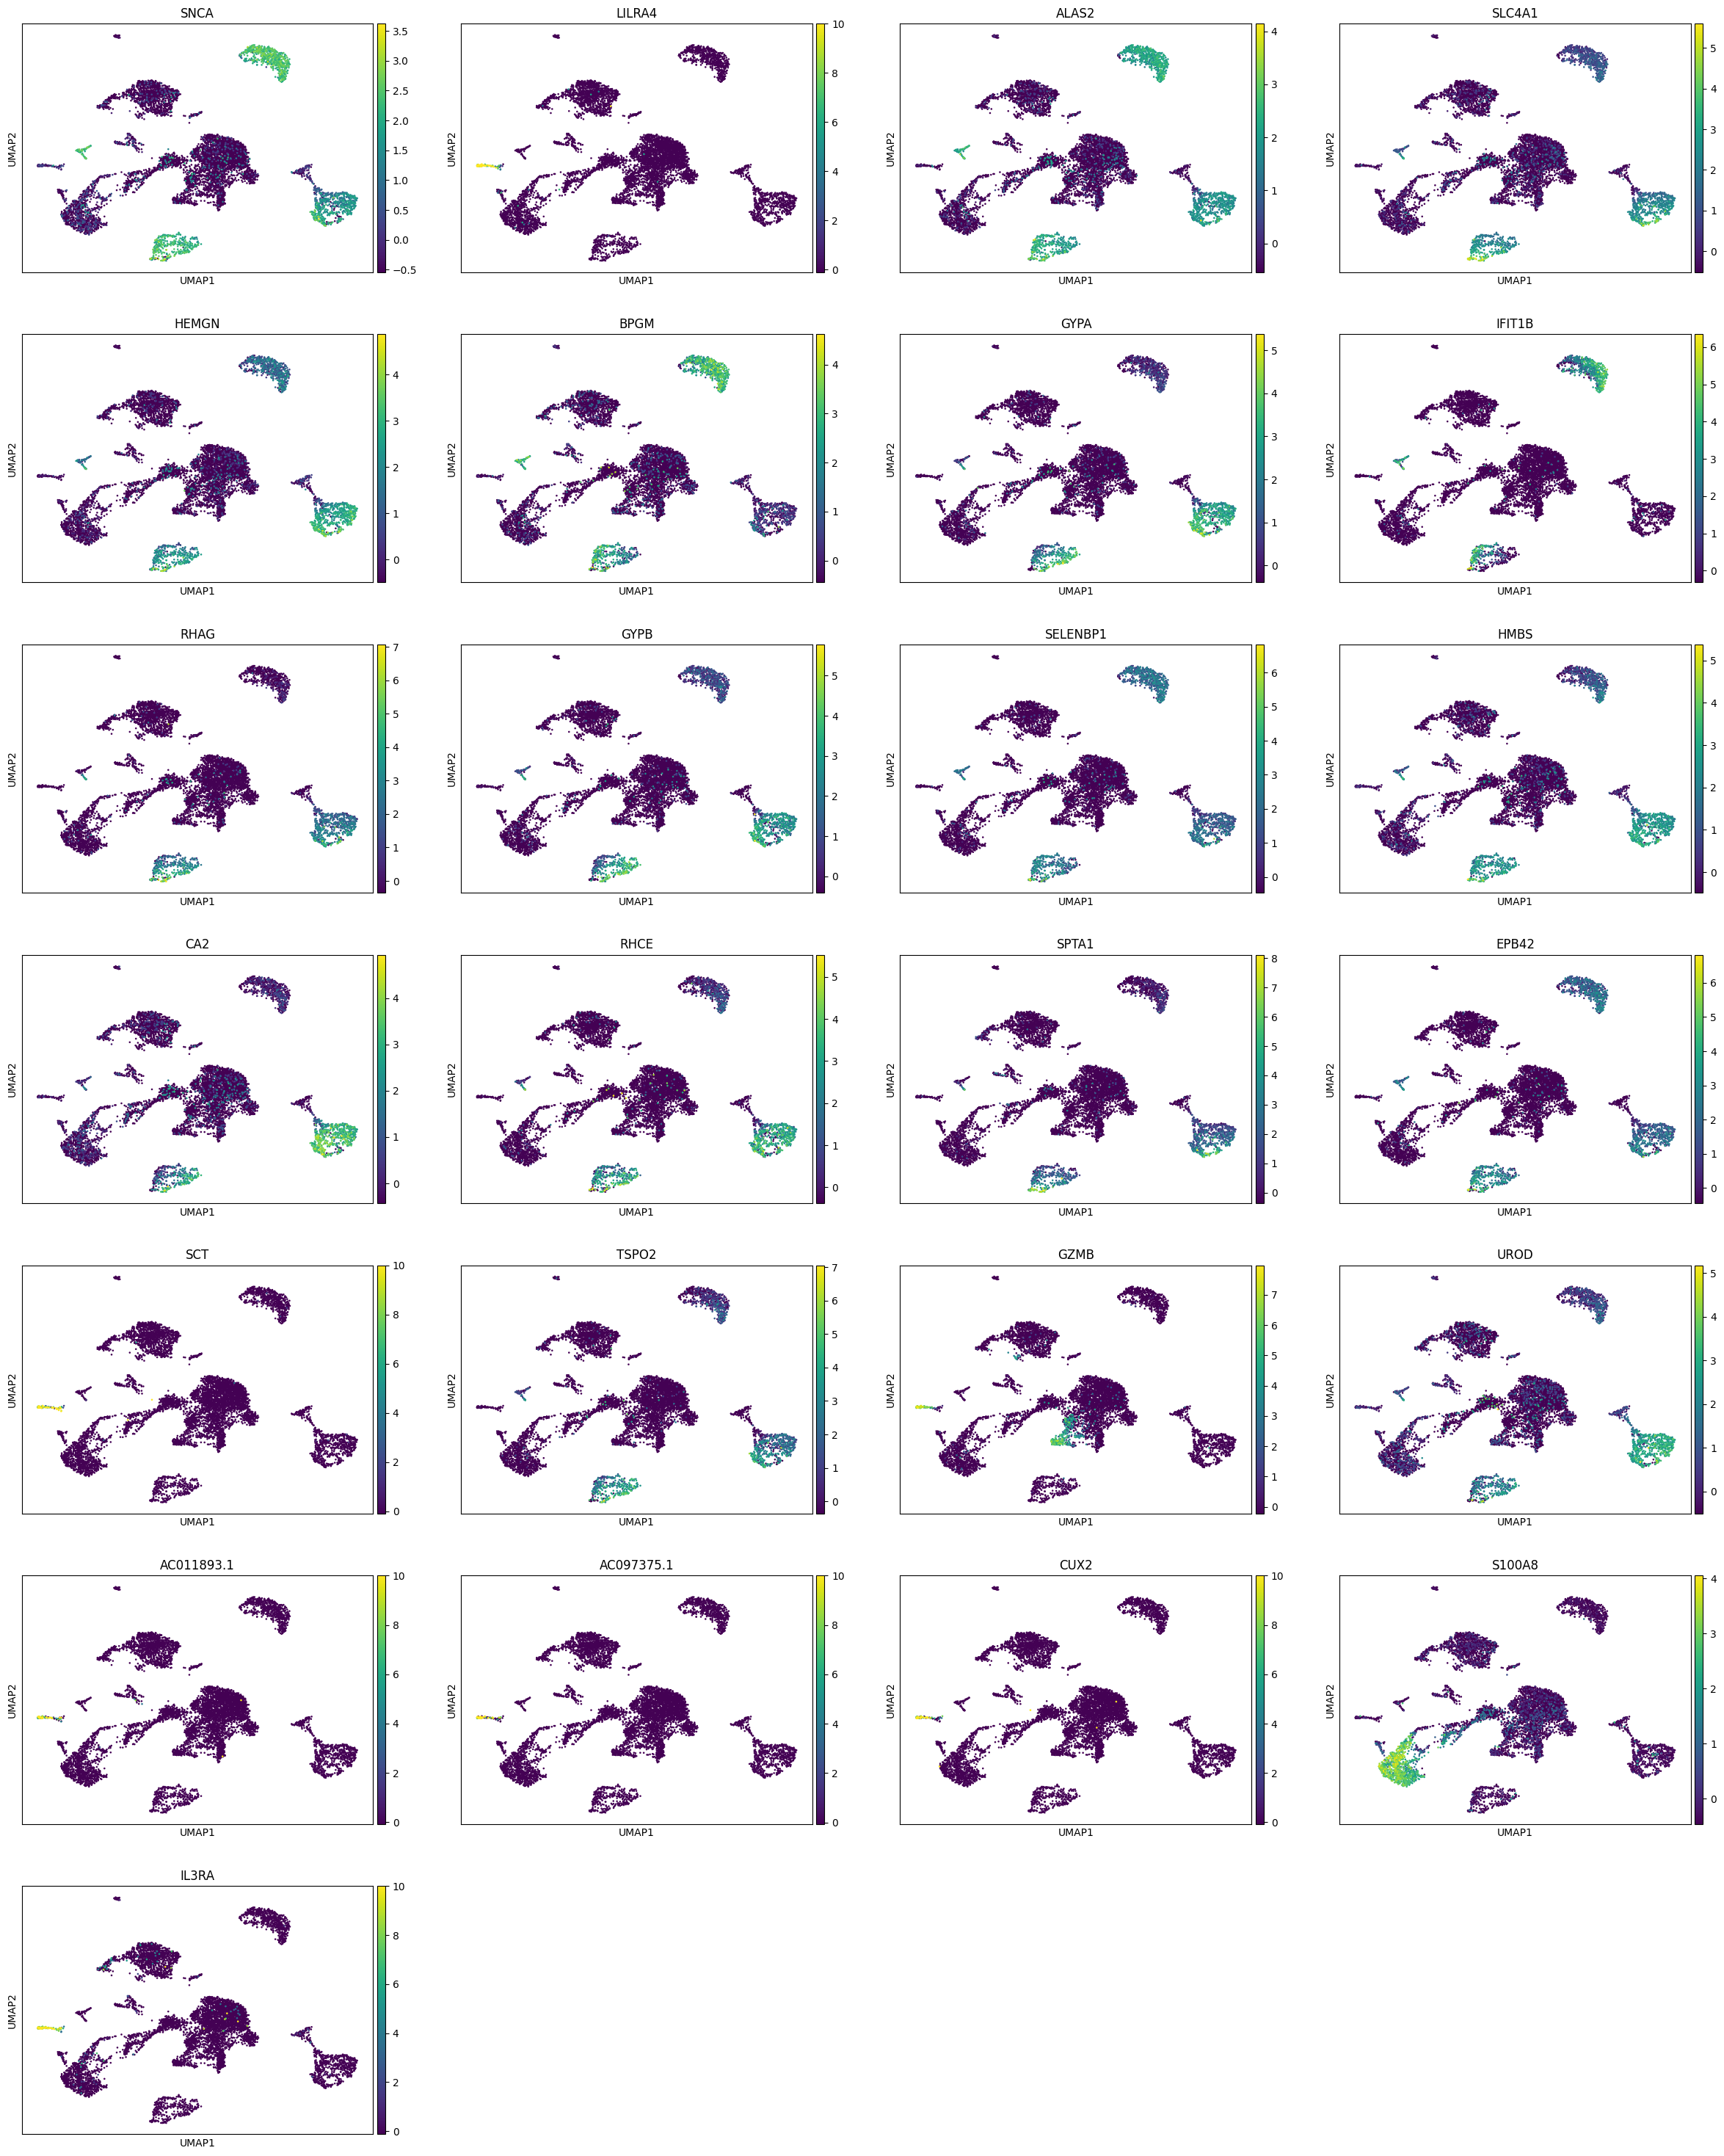

In [55]:
sc.pl.umap(adata, color = list(top.index))

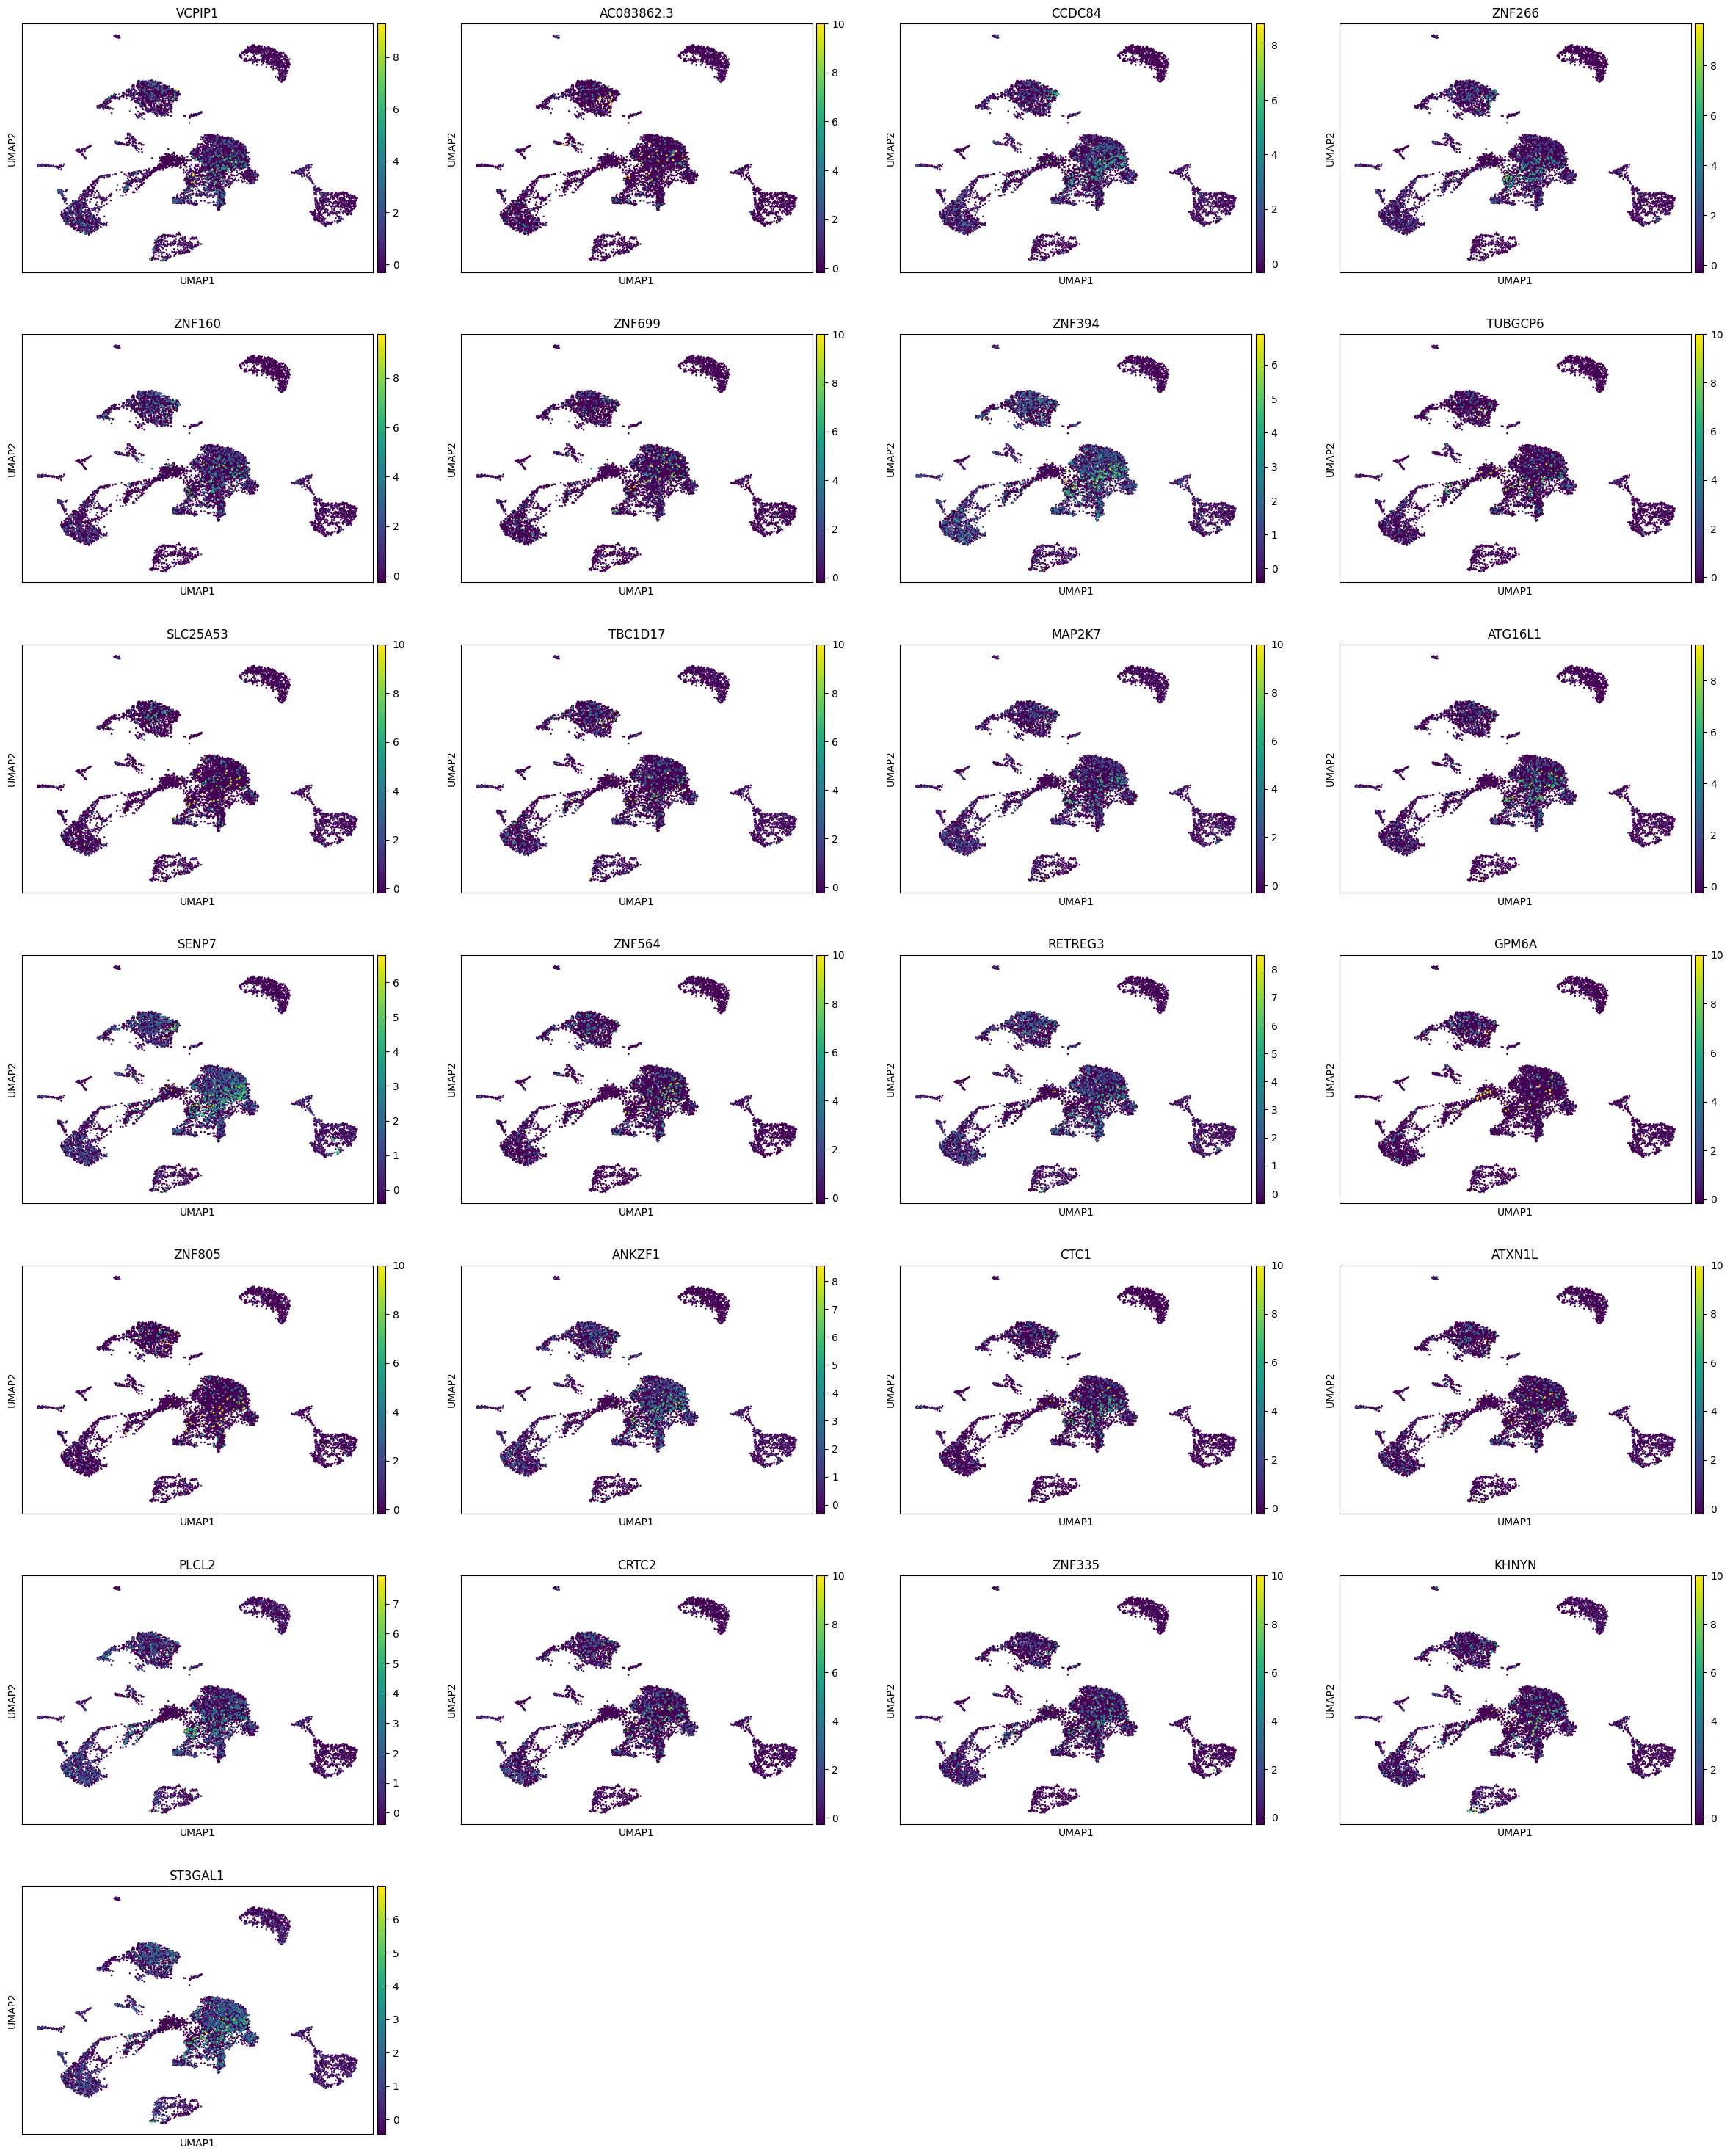

In [56]:
sc.pl.umap(adata, color = list(bot.index))

In [57]:
def find_knee(lmd_scores):
    
    v_sorted = np.sort(lmd_scores)
    
    x = np.arange(1, v_sorted.size + 1)
    x1, y1 = x[0], v_sorted[0]
    x2, y2 = x[-1], v_sorted[-1]
    dx, dy = x2 - x1, y2 - y1
    norm = np.sqrt(dx * dx + dy * dy) + 1e-12
    A, B, C = dy, -dx, dx * y1 - dy * x1
    dist = np.abs(A * x + B * v_sorted + C) / norm
    knee = int(np.argmax(dist))

    return knee

In [58]:
knee = find_knee(lmd_scores)

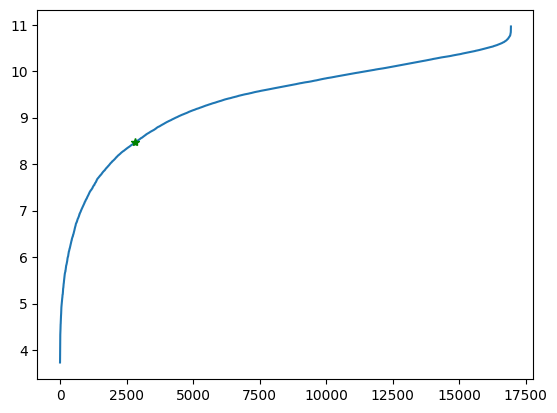

In [109]:
plt.plot(sorted(lmd_scores))
plt.plot(knee, sorted(lmd_scores)[knee], 'g*')

plt.show()

In [60]:
LMDs = list(lmd_scores.sort_values()[:knee].index)

In [61]:
nb_end = time.time()
nb_time = nb_end - nb_start
print(f"Total execution time: {nb_time} seconds")

Total execution time: 60.33557319641113 seconds


In [62]:
def pyLMD(path, max_time = 2**20, device = 'cpu'):
    
    if device == 'gpu':
        import cupy as cp
        import cudf
        from cupyx.scipy import sparse as csp
        from cupyx.scipy.stats import entropy as cen
        import cudf as cd
        import rapids_singlecell as rsc
    elif device == "cpu":
        print('WARNING: Only running on CPU, please ensure this is intended.')
    else:
        raise ValueError("Device should either be CPU or GPU.")

    xsc = get_xsc(device)

    adata = sc.read_10x_h5(path)
    adata.var_names_make_unique()

    if device == 'gpu':
        rsc.get.anndata_to_GPU(adata)
    
    xsc.pp.filter_cells(adata, min_genes=100)
    xsc.pp.filter_genes(adata, min_cells=3)
    
    raw_adata = adata.copy()
    
    if device == 'gpu':      
        dat = pd.DataFrame(
            raw_adata.X.get().T.toarray() if not isinstance(raw_adata.X, np.ndarray) else raw_adata.X.T,
            index=adata.var_names,       # genes
            columns=adata.obs_names      # cells
        )
    else:
        dat = pd.DataFrame(
            raw_adata.X.T.toarray() if not isinstance(raw_adata.X, np.ndarray) else raw_adata.X.T,
            index=adata.var_names,       # genes
            columns=adata.obs_names      # cells
        )
    
    xsc.pp.normalize_total(adata)
    xsc.pp.log1p(adata)
    xsc.pp.highly_variable_genes(adata, n_top_genes=2000)
    xsc.pp.scale(adata,max_value=10)
    xsc.tl.pca(adata)
    if device == 'gpu':
        rsc.get.anndata_to_CPU(adata)
    xsc.pp.neighbors(adata)
    xsc.tl.umap(adata)
    
    cell_medians = np.median(dat, axis=0)
    mask = dat > cell_medians
    
    gene_detected_count = mask.sum(axis=1)
    
    selected_genes = (gene_detected_count >= 10) & (gene_detected_count <= dat.shape[1] * 0.3)
    
    adata = adata[:, selected_genes].copy()
    raw_adata = raw_adata[:, selected_genes].copy()
    dat = dat[selected_genes]
    
    feature_space = adata.obsm['X_pca'][:, :20]
    
    W = build_network(feature_space, n_neighbors=5)
    
    rho = rowwise_normalize(dat, W)
    
    P_ls = construct_diffusion_operators(W, device, max_time=max_time)
    
    score_df = calculate_score_profile(
        W = W,
        rho = rho,
        P_ls = P_ls,
        device = device
    )
    
    norm_scores, lmd_scores = obtain_lmds(score_df)
    
    sort_score = lmd_scores.sort_values()
    
    knee = find_knee(lmd_scores)
    
    LMDs = list(lmd_scores.sort_values()[:knee].index)

    return LMDs

In [63]:
start_time = time.time()
LMDs = pyLMD(path, max_time = 2**3, device = 'cpu')
end_time = time.time()
execution_time = end_time - start_time
print(f"{max_t} Diffusion Execution time: {execution_time} seconds")

/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Creating diffusion operators...
Step 1: max deviation from convergence = 8713.0
Step 2: max deviation from convergence = 25804572.0
Step 3: max deviation from convergence = 10940050.0
Max diffusion time: 8
Total operators created: 4
Completed scoring for time 0
Completed scoring for time 2
Completed scoring for time 4
Completed scoring for time 8
1048576 Diffusion Execution time: 131.2195200920105 seconds


In [64]:
start_time = time.time()
LMDs = pyLMD(path, max_time = 2**4, device = 'gpu')
end_time = time.time()
execution_time = end_time - start_time
print(f"{max_t} Diffusion Execution time: {execution_time} seconds")

/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 72 cells that have less than 100 genes expressed
filtered out 14926 genes that are detected in less than 3 cells
Creating diffusion operators...
Step 1: max deviation from convergence = 8713.0
Step 2: max deviation from convergence = 25809436.0
Step 3: max deviation from convergence = 10944500.0
Step 4: max deviation from convergence = 7396620.0
Max diffusion time: 16
Total operators created: 5
Completed scoring for time 0
Completed scoring for time 2
Completed scoring for time 4
Completed scoring for time 8
Completed scoring for time 16
1048576 Diffusion Execution time: 10.144879341125488 seconds
